# Diamond Price Prediction using Neural Networks

This notebook explores predicting diamond prices using neural networks. We'll analyze a dataset containing various diamond characteristics including carat weight, cut quality, color grade, clarity, and physical measurements to build a model that can accurately predict diamond prices.


## Approach
1. Data preprocessing including:
   - Converting numeric features to float type
   - Encoding categorical variables using Label Encoding
   - Splitting into features (X) and target (y)
2. Model building using neural networks
3. Evaluation of prediction accuracy

## 1. Data Preprocessing


In [20]:
import pandas as pd
import numpy as np

# Load the diamond data file
df = pd.read_csv('diamond-data.txt', sep='\t')

# Drop the first row which contains headers
df = df.iloc[1:]

# Assign column names based on the data
df.columns = ['ID', 'Carat', 'Cut', 'Color', 'Clarity', 'Depth', 'Table', 
             'Price', 'X', 'Y', 'Z', 'Supplier']

# Convert numeric columns to float type
numeric_columns = ['Carat', 'Depth', 'Table', 'Price', 'X', 'Y', 'Z']
df[numeric_columns] = df[numeric_columns].astype(float)

# Convert categorical columns to appropriate types
categorical_columns = ['Cut', 'Color', 'Clarity', 'Supplier']
df[categorical_columns] = df[categorical_columns].astype('category')


In [22]:
from sklearn.preprocessing import LabelEncoder

# Create a copy of the dataframe for preprocessing
df_processed = df.copy()

# Handle categorical variables using Label Encoding
label_encoders = {}
for cat_col in categorical_columns:
    label_encoders[cat_col] = LabelEncoder()
    df_processed[cat_col] = label_encoders[cat_col].fit_transform(df_processed[cat_col])

# Split features and target
X = df_processed.drop('Price', axis=1)  # Features
y = df_processed['Price']  # Target variable

print("Data preprocessing completed:")
print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")


Data preprocessing completed:
Features shape: (53939, 11)
Target shape: (53939,)


## 2. Model Building and Training

The data is split into 20% training and 80% testing. The neural network has 

In [30]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# First split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=42)

# Convert data to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train.values)
y_train_tensor = torch.FloatTensor(y_train.values).reshape(-1, 1)

# Create custom dataset
class DiamondDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Create training dataset and loader
train_dataset = DiamondDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Define the neural network
class DiamondPriceNet(nn.Module):
    def __init__(self, input_size):
        super(DiamondPriceNet, self).__init__()
        self.layer1 = nn.Linear(input_size, 64)
        self.layer2 = nn.Linear(64, 32)
        self.layer3 = nn.Linear(32, 1)
        self.relu = nn.ReLU()
        print(f"Input Count: {input_size}")
        
    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.relu(self.layer2(x))
        x = self.layer3(x)
        return x

# Initialize the model
model = DiamondPriceNet(input_size=X.shape[1]).to(device)

# Define loss function and optimizer
criterion = nn.MSELoss()
# For L1 regularization, we'll need to manually add L1 penalty in the training loop
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)  # We'll add L1 regularization during training
l1_lambda = 0.05  # L1 regularization strength
#optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.01)  # L2 regularization with weight_decay

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch_X, batch_y in train_loader:
        # Move batch to GPU
        batch_X = batch_X.to(device)
        batch_y = batch_y.to(device)
        
        # Forward pass
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    # Print progress every n epochs
    if (epoch + 1) % 10 == 0:
        avg_loss = total_loss / len(train_loader)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')

print("Training completed!")

# Convert test data to tensors
test_X = torch.FloatTensor(X_test.values).to(device)
test_y = torch.FloatTensor(y_test.values).reshape(-1, 1).to(device)

# Set model to evaluation mode
model.eval()

# Get predictions for test set
with torch.no_grad():
    test_predictions = model(test_X).cpu().numpy()
    
# Get actual test values
test_y_actual = test_y.cpu().numpy()


Using device: cuda
Input Count: 11
Epoch [10/100], Loss: 3278164.4140
Epoch [20/100], Loss: 2251289.1088
Epoch [30/100], Loss: 2071556.3771
Epoch [40/100], Loss: 973891.7362
Epoch [50/100], Loss: 2871996.6185
Epoch [60/100], Loss: 1489373.3997
Epoch [70/100], Loss: 1582396.0987
Epoch [80/100], Loss: 1645414.3001
Epoch [90/100], Loss: 3808735.9751
Epoch [100/100], Loss: 3917466.2671
Training completed!


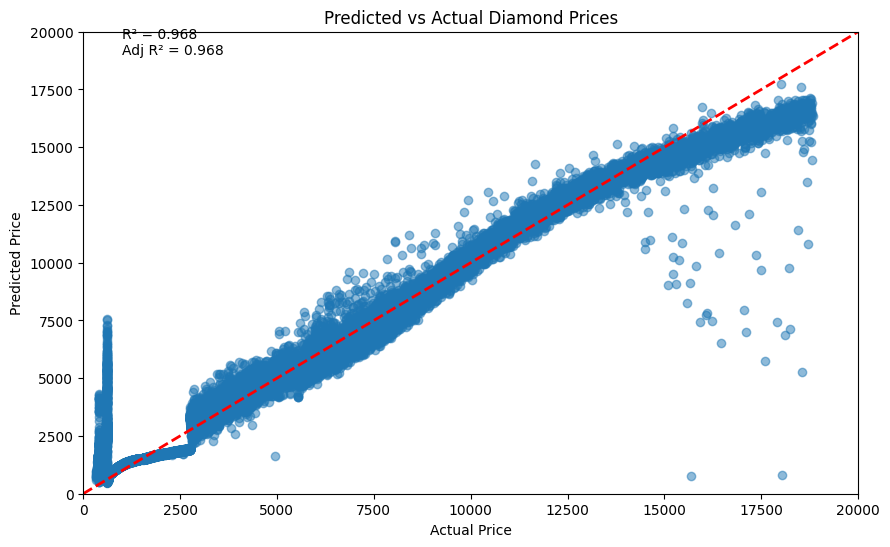

Root Mean Squared Error: $714.89
Mean Absolute Error: $420.04


In [26]:
# Create scatter plot
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.scatter(test_y_actual, test_predictions, alpha=0.5)
plt.plot([0, 20000], [0, 20000], 'r--', lw=2)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Predicted vs Actual Diamond Prices')

# Set axis limits
plt.xlim(0, 20000)
plt.ylim(0, 20000)

# Calculate and display R² and adjusted R² scores
from sklearn.metrics import r2_score
r2 = r2_score(test_y_actual, test_predictions)
n = len(test_y_actual)
p = 1  # number of predictors
adj_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
plt.text(0.05, 0.95, f'R² = {r2:.3f}\nAdj R² = {adj_r2:.3f}', transform=plt.gca().transAxes)

plt.show()

# Print some error metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

mse = mean_squared_error(test_y_actual, test_predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test_y_actual, test_predictions)

print(f'Root Mean Squared Error: ${rmse:.2f}')
print(f'Mean Absolute Error: ${mae:.2f}')

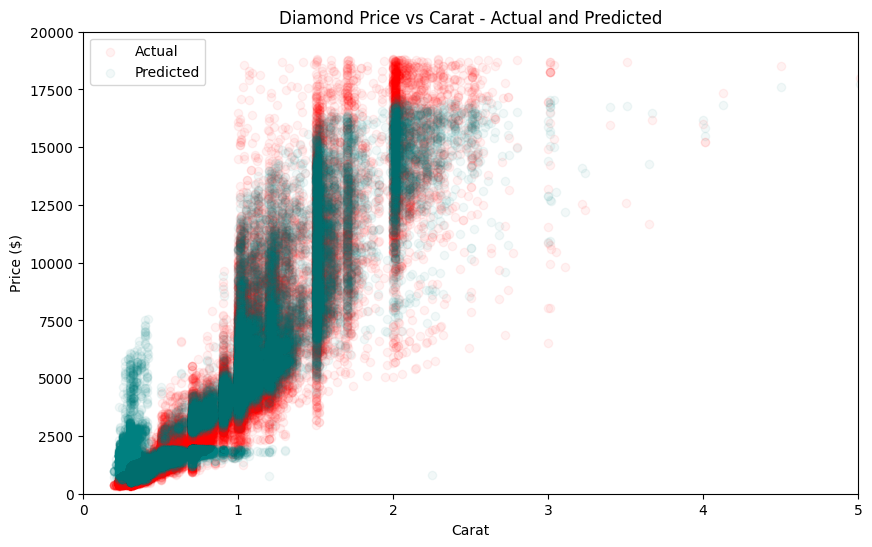

In [28]:
# Create scatter plot of price vs carat
plt.figure(figsize=(10,6))
plt.scatter(df['Carat'], df['Price'], alpha=0.05, label='Actual', color='red')

# Add predicted values from test set
plt.scatter(X_test['Carat'], test_predictions, alpha=0.05, color='teal', label='Predicted')

plt.xlabel('Carat')
plt.ylabel('Price ($)')
plt.title('Diamond Price vs Carat - Actual and Predicted')
plt.legend()

# Set axis limits
plt.xlim(0, 5)
plt.ylim(0, 20000)

plt.show()
